# Paraphrase Detection on MSRP

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import numpy as np
import nltk
import string
from numpy import array, asarray, zeros
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, LSTM, Bidirectional
from keras import optimizers
from keras.layers.normalization import BatchNormalization

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Training Set

In [82]:
with open('msr_paraphrase_train.txt', encoding = 'utf8') as msr_file:
    sent1 = []
    sent2 = []
    is_paraphrase = []
    for index, sent in enumerate(msr_file):
        if index != 0:
            values = sent.split("\t")
            sent1.append(values[3][:-1])
            sent2.append(values[4][:-1])
            is_paraphrase.append(int(values[0]))

all_sents1 = sent1
all_sents2 = sent2
labels_train = is_paraphrase

In [83]:
tok1 = Tokenizer()
tok1.fit_on_texts(all_sents1)
vocab_size_sents1 = len(tok1.word_index) + 1
encoded_sents1 = tok1.texts_to_sequences(all_sents1)

In [84]:
tok2 = Tokenizer()
tok2.fit_on_texts(all_sents2)
vocab_size_sents2 = len(tok2.word_index) + 1
print(vocab_size_sents2)
encoded_sents2 = tok2.texts_to_sequences(all_sents2)

11758


In [85]:
vocab_size = vocab_size_sents1 + vocab_size_sents2
vocab_size

23642

### Paddings

In [86]:
max_length = 20
padded_sents1 = pad_sequences(encoded_sents1, maxlen=max_length, \
                            padding='post')
padded_sents1

array([[ 1420,   434,    28, ...,     0,     0,     0],
       [ 5734,  1145,  5735, ...,     0,     0,     0],
       [   39,    31,   607, ...,   310,     0,     0],
       ...,
       [   13,    38,   613, ...,   963,     0,     0],
       [ 2089,   168,    40, ...,   152, 11881, 11882],
       [    9,   705,  3807, ...,   664,  3037,     7]], dtype=int32)

In [87]:
padded_sents2 = pad_sequences(encoded_sents2, maxlen=max_length, \
                              padding='post')
padded_sents2

array([[ 1932,     2,   144, ...,     0,     0,     0],
       [ 5758,  2326,  5759, ...,     4,   872,     0],
       [    8,   207,   112, ...,   934,     0,     0],
       ...,
       [11752,     7,    10, ...,     0,     0,     0],
       [ 2886,   946,    36, ..., 11755,     0,     0],
       [    4,     5,   136, ..., 11757,     0,     0]], dtype=int32)

### Embeddings

In [88]:
embeddings_index = dict()
with open('glove.6B.300d.txt', encoding = "utf-8") as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [89]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 300))
filled_by_tok1 = 0

for word, ind in tok1.word_index.items():
    filled_by_tok1 = ind
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[ind] = embedding_vector

for word, ind in tok2.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[filled_by_tok1+ind] = embedding_vector
        

### concatenate both paraphrases

In [90]:
training_set = [np.concatenate([padded_sents1[i],\
                                padded_sents1[i]]) for i in range(len(padded_docs))]

training_set = np.array(training_set)
training_set

array([[ 1420,   434,    28, ...,     0,     0,     0],
       [ 5734,  1145,  5735, ...,     0,     0,     0],
       [   39,    31,   607, ...,   310,     0,     0],
       ...,
       [   13,    38,   613, ...,   963,     0,     0],
       [ 2089,   168,    40, ...,   152, 11881, 11882],
       [    9,   705,  3807, ...,   664,  3037,     7]], dtype=int32)

## Test Set

In [91]:
with open('msr_paraphrase_test.txt', encoding = 'utf8') as msr_file:
    sent1 = []
    sent2 = []
    is_paraphrase = []
    for index, sent in enumerate(msr_file):
        if index != 0:
            values = sent.split("\t")
            sent1.append(values[3][:-1])
            sent2.append(values[4][:-1])
            is_paraphrase.append(int(values[0]))

all_sents1_test = sent1
all_sents2_test = sent2
labels_test = is_paraphrase

### encode

In [92]:
sents1 = all_sents1_test
sents2 = all_sents2_test

tok1_test = Tokenizer()
tok1_test.fit_on_texts(sents1)
encoded_sents1_test = tok1_test.texts_to_sequences(sents1)

tok2_test = Tokenizer()
tok2_test.fit_on_texts(sents2)
encoded_sents2_test = tok2_test.texts_to_sequences(sents2)

### padding

In [93]:
padded_sents1_test = pad_sequences(encoded_sents1_test, maxlen=max_length, \
                              padding='post')
padded_sents2_test = pad_sequences(encoded_sents2_test, maxlen=max_length, \
                               padding='post')

test_set = []
test_set = [np.concatenate((padded_sents1_test[i],padded_sents2_test[i])) \
                for i in range(len(t_padded_docs))]
test_set = array(test_set)
(training_set)

array([[ 1420,   434,    28, ...,     0,     0,     0],
       [ 5734,  1145,  5735, ...,     0,     0,     0],
       [   39,    31,   607, ...,   310,     0,     0],
       ...,
       [   13,    38,   613, ...,   963,     0,     0],
       [ 2089,   168,    40, ...,   152, 11881, 11882],
       [    9,   705,  3807, ...,   664,  3037,     7]], dtype=int32)

In [94]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall) / (precision+recall + K.epsilon()))


# MODELS

## Feedforward network

In [95]:
# feed_fwd_model
feed_fwd_model = Sequential()

feed_fwd_model.add(Embedding(vocab_size, 300, \
                             weights=[embedding_matrix], \
                                 input_length=40, trainable=False))
feed_fwd_model.add(Flatten())  # to make dim valid for the next layer

feed_fwd_model.add(Dense(300, activation = 'relu'))
feed_fwd_model.add(Dense(150, input_dim = 300, activation='relu'))
feed_fwd_model.add(Dense(1, input_dim = 150, activation='sigmoid'))

feed_fwd_model.compile(loss='binary_crossentropy', \
                       optimizer='adam', \
                       metrics=['acc',f1_m,precision_m, recall_m])
feed_fwd_model.summary()
feed_fwd_model_hist = feed_fwd_model.fit(training_set, labels_train, validation_data=\
                                           (test_set, labels_test), nb_epoch = 10,\
                                               batch_size=64)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 300)           7092600   
_________________________________________________________________
flatten_5 (Flatten)          (None, 12000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 300)               3600300   
_________________________________________________________________
dense_16 (Dense)             (None, 150)               45150     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 151       
Total params: 10,738,201
Trainable params: 3,645,601
Non-trainable params: 7,092,600
_________________________________________________________________


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 4074 samples, validate on 1725 samples
Epoch 1/10
4074/4074 [==============================] - 8s 2ms/step - loss: 0.6159 - acc: 0.6851 - f1_m: 0.7941 - precision_m: 0.7048 - recall_m: 0.9208 - val_loss: 0.6322 - val_acc: 0.6638 - val_f1_m: 0.7955 - val_precision_m: 0.6660 - val_recall_m: 0.9912
Epoch 2/10
4074/4074 [==============================] - 6s 1ms/step - loss: 0.4128 - acc: 0.8127 - f1_m: 0.8665 - precision_m: 0.8294 - recall_m: 0.9157 - val_loss: 0.7148 - val_acc: 0.6591 - val_f1_m: 0.7858 - val_precision_m: 0.6724 - val_recall_m: 0.9486
Epoch 3/10
4074/4074 [==============================] - 7s 2ms/step - loss: 0.1653 - acc: 0.9396 - f1_m: 0.9554 - precision_m: 0.9481 - recall_m: 0.9649 - val_loss: 0.8210 - val_acc: 0.6006 - val_f1_m: 0.7213 - val_precision_m: 0.6687 - val_recall_m: 0.7864
Epoch 4/10
4074/4074 [==============================] - 6s 2ms/step - loss: 0.0663 - acc: 0.9833 - f1_m: 0.9875 - precision_m: 0.9855 - recall_m: 0.9899 - val_loss: 1.0760 - val_

#### Plots

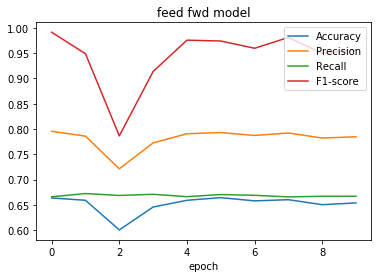

In [96]:
plt.plot(feed_fwd_model_hist.history['val_acc'])
plt.plot(feed_fwd_model_hist.history['val_f1_m'])
plt.plot(feed_fwd_model_hist.history['val_precision_m'])
plt.plot(feed_fwd_model_hist.history['val_recall_m'])


plt.title('feed fwd model')
plt.xlabel('epoch')
plt.legend(['Accuracy','Precision','Recall','F1-score' ], loc='upper right')
plt.show()

## LSTM



In [105]:
# LSTM Model
lstm = Sequential() 
lstm.add(Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False))
# model.add(Flatten())
lstm.add(LSTM(300, dropout = 0.5))
lstm.add(Dense(150, input_dim = 300, activation='relu'))
lstm.add(BatchNormalization())
lstm.add(Dense(1, input_dim = 150, activation='sigmoid'))

# compile the model
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
# summarize the model
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 300)         7092600   
_________________________________________________________________
lstm_5 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_24 (Dense)             (None, 150)               45150     
_________________________________________________________________
batch_normalization_3 (Batch (None, 150)               600       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 151       
Total params: 7,859,701
Trainable params: 766,801
Non-trainable params: 7,092,900
_________________________________________________________________


Fitting the model

In [107]:
lstm_hist = lstm.fit(training_set, labels_train, validation_data=\
                                           (test_set, t_labels), nb_epoch = 10,\
                                               batch_size=64)


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 4074 samples, validate on 1725 samples
Epoch 1/10
4074/4074 [==============================] - 29s 7ms/step - loss: 0.6870 - acc: 0.6019 - f1_m: 0.7061 - precision_m: 0.6941 - recall_m: 0.7339 - val_loss: 0.6348 - val_acc: 0.6504 - val_f1_m: 0.7844 - val_precision_m: 0.6632 - val_recall_m: 0.9634
Epoch 2/10
4074/4074 [==============================] - 24s 6ms/step - loss: 0.6216 - acc: 0.6745 - f1_m: 0.7887 - precision_m: 0.6980 - recall_m: 0.9136 - val_loss: 0.8508 - val_acc: 0.6649 - val_f1_m: 0.7975 - val_precision_m: 0.6649 - val_recall_m: 1.0000
Epoch 3/10
4074/4074 [==============================] - 24s 6ms/step - loss: 0.6034 - acc: 0.6838 - f1_m: 0.7968 - precision_m: 0.7021 - recall_m: 0.9265 - val_loss: 0.8724 - val_acc: 0.4475 - val_f1_m: 0.3753 - val_precision_m: 0.7599 - val_recall_m: 0.2540
Epoch 4/10
4074/4074 [==============================] - 23s 6ms/step - loss: 0.5971 - acc: 0.6851 - f1_m: 0.7932 - precision_m: 0.7086 - recall_m: 0.9063 - val_loss: 0.6549 - 

##### Plots

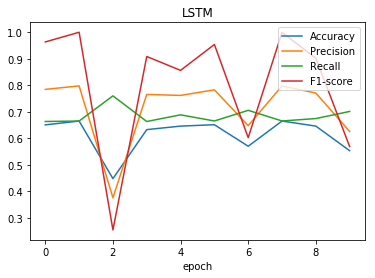

In [108]:

plt.plot(lstm_hist.history['val_acc'])
plt.plot(lstm_hist.history['val_f1_m'])
plt.plot(lstm_hist.history['val_precision_m'])
plt.plot(lstm_hist.history['val_recall_m'])


plt.title('LSTM')
plt.xlabel('epoch')
plt.legend(['Accuracy','Precision','Recall','F1-score' ], loc='upper right')
plt.show()

## BiLSTM 

In [99]:
# BLSTM
bilstm_model = Sequential()
bilstm_model.add(Embedding(vocab_size, 300,\
                           weights=[embedding_matrix],\
                               trainable=False))
bilstm_model.add(Bidirectional(LSTM(300)))
bilstm_model.add(Dense(150, input_dim = 300, \
                       activation='relu'))
bilstm_model.add(Dense(1, input_dim = 150, \
                       activation='sigmoid'))
bilstm_model.compile(loss='binary_crossentropy', \
                     optimizer='adam', \
                     metrics = ['acc',f1_m,precision_m, recall_m])
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 300)         7092600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_20 (Dense)             (None, 150)               90150     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 151       
Total params: 8,625,301
Trainable params: 1,532,701
Non-trainable params: 7,092,600
_________________________________________________________________


In [100]:
bilstm_hist = bilstm_model.fit(training_set, labels_train, \
                               validation_data=(test_set, t_labels),\
                                   nb_epoch = 10, batch_size=64)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 4074 samples, validate on 1725 samples
Epoch 1/10
4074/4074 [==============================] - 49s 12ms/step - loss: 0.6041 - acc: 0.6841 - f1_m: 0.7935 - precision_m: 0.6920 - recall_m: 0.9489 - val_loss: 0.6327 - val_acc: 0.6643 - val_f1_m: 0.7963 - val_precision_m: 0.6659 - val_recall_m: 0.9941
Epoch 2/10
4074/4074 [==============================] - 44s 11ms/step - loss: 0.5665 - acc: 0.7106 - f1_m: 0.8099 - precision_m: 0.7253 - recall_m: 0.9240 - val_loss: 0.6385 - val_acc: 0.6429 - val_f1_m: 0.7737 - val_precision_m: 0.6669 - val_recall_m: 0.9253
Epoch 3/10
4074/4074 [==============================] - 41s 10ms/step - loss: 0.5272 - acc: 0.7359 - f1_m: 0.8210 - precision_m: 0.7530 - recall_m: 0.9098 - val_loss: 0.6778 - val_acc: 0.5855 - val_f1_m: 0.6804 - val_precision_m: 0.6992 - val_recall_m: 0.6664
Epoch 4/10
4074/4074 [==============================] - 39s 10ms/step - loss: 0.4653 - acc: 0.7833 - f1_m: 0.8467 - precision_m: 0.8085 - recall_m: 0.8985 - val_loss: 0.686

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

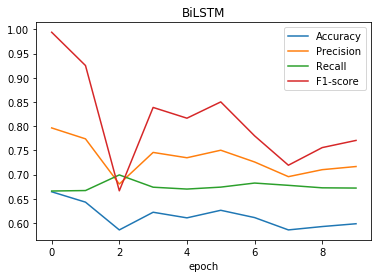

In [102]:
plt.plot(bilstm_hist.history['val_acc'])
plt.plot(bilstm_hist.history['val_f1_m'])
plt.plot(bilstm_hist.history['val_precision_m'])
plt.plot(bilstm_hist.history['val_recall_m'])


plt.title('BiLSTM')
# plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy','Precision','Recall','F1-score' ], loc='upper right')
plt.show()